In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
from time import time
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 5
N_JOBS = 6
SEED = 2016
SHIFT = 0

In [2]:
# Get data
train = pd.read_csv("raw_data/X_train.csv")
test = pd.read_csv("raw_data/X_test.csv")
y = pd.read_csv("raw_data/y.csv")
print("train : " + str(train.shape))
print("test : " + str(test.shape))
print("y : " + str(y.shape))

test_ids = test.ID

train : (448169, 33)
test : (300891, 33)
y : (448169, 2)


In [3]:
display(train.head())
display(y.head())

,ID,hlres_50,green_5000,hldres_50,daytime,route_100,precipintensity,precipprobability,hlres_1000,temperature,...,route_500,hlres_500,hlres_100,pollutant,industry_1000,zone_id,windbearingcos,windspeed,hldres_500,hldres_1000
0,0,nan,5172542.500,3755.190,72.000,nan,0.610,0.610,nan,9.490,...,nan,nan,nan,NO2,nan,0.000,0.809,6.550,357436.188,1542650.000
1,1,nan,5172542.500,3755.190,72.000,nan,0.610,0.610,nan,9.490,...,nan,nan,nan,PM10,nan,0.000,0.809,6.550,357436.188,1542650.000
2,2,nan,5172542.500,3755.190,73.000,nan,0.097,0.140,nan,8.220,...,nan,nan,nan,NO2,nan,0.000,0.998,4.470,357436.188,1542650.000
3,3,nan,5172542.500,3755.190,73.000,nan,0.097,0.140,nan,8.220,...,nan,nan,nan,PM10,nan,0.000,0.998,4.470,357436.188,1542650.000
4,4,nan,5172542.500,3755.190,74.000,nan,0.000,0.000,nan,7.580,...,nan,nan,nan,NO2,nan,0.000,0.995,4.110,357436.188,1542650.000


,ID,TARGET
0,0,43.000
1,1,21.000
2,2,9.000
3,3,22.000
4,4,6.000


In [4]:
# Check for duplicate ids
idsUniqueTrain = len(set(train.ID))
idsTotalTrain = train.shape[0]
idsDupliTrain = idsTotalTrain - idsUniqueTrain
print("There are " + str(idsDupliTrain) + " duplicate IDs for " + str(idsTotalTrain) + " total entries in Train")
idsUniqueTest = len(set(test.ID))
idsTotalTest = test.shape[0]
idsDupliTest = idsTotalTest - idsUniqueTest
print("There are " + str(idsDupliTest) + " duplicate IDs for " + str(idsTotalTest) + " total entries in Test")

There are 0 duplicate IDs for 448169 total entries in Train
There are 0 duplicate IDs for 300891 total entries in Test


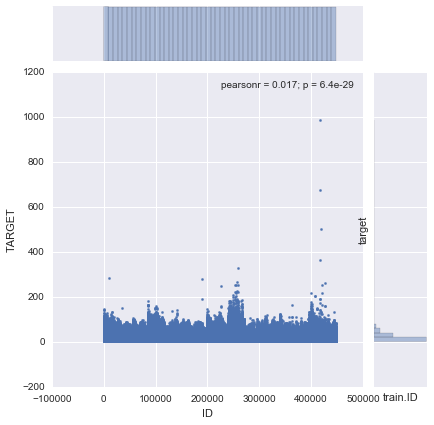

There may actually be some information in the ID variable : some spikes observed


In [5]:
# Look for information in the id variable before dropping it
sns.jointplot(x = train.ID, y = y.TARGET, s = 5)
plt.xlabel("train.ID")
plt.ylabel("target")
plt.show()
print("There may actually be some information in the ID variable : some spikes observed")

Target variable 'TARGET' is continuous -> regression problem


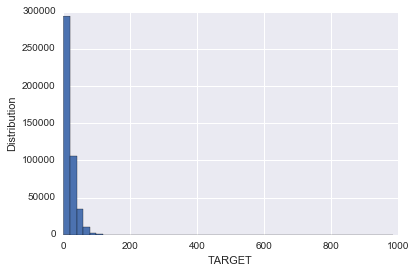

Target variable is strongly skewed to the right
We'll log transform it, so that errors in predicting both ends of the loss spectrum will affect the result equally


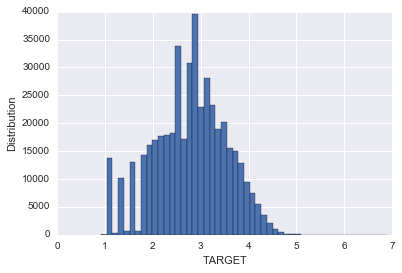

It's better, but now the left of the distrib could look better. Let's try to add a shift constant.


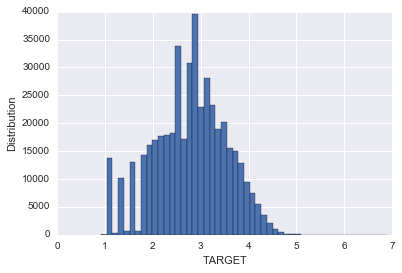

It's a bit more normal-looking


In [6]:
# Looking at the target variable distribution
print("Target variable 'TARGET' is continuous -> regression problem")
plt.hist(y.TARGET, bins = 50)
plt.xlabel("TARGET")
plt.ylabel("Distribution")
plt.show()
print("Target variable is strongly skewed to the right")
print("We'll log transform it, so that errors in predicting both ends of the loss spectrum will affect the result equally")
plt.hist(np.log1p(y.TARGET), bins = 50)
plt.xlabel("TARGET")
plt.ylabel("Distribution")
plt.show()
print("It's better, but now the left of the distrib could look better. Let's try to add a shift constant.")
plt.hist(np.log1p(y.TARGET + SHIFT), bins = 50)
plt.xlabel("TARGET")
plt.ylabel("Distribution")
plt.show()
print("It's a bit more normal-looking")

In [7]:
# Transform target variable
y.TARGET = np.log1p(y.TARGET + SHIFT)

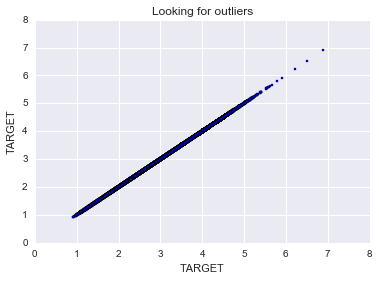

There are a few outliers, we may try to remove those to improve predictions accuracy


In [8]:
# Looking for outliers in the target variable 
plt.scatter(y.TARGET, y.TARGET, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers")
plt.xlabel("TARGET")
plt.ylabel("TARGET")
plt.show()
print("There are a few outliers, we may try to remove those to improve predictions accuracy")

In [9]:
# Remove top X outliers
oldNbRows = train.shape[0]
outliers = y[y.TARGET > 400].index
train.drop(outliers, axis = 0, inplace = True)
y.drop(outliers, axis = 0, inplace = True)
print("Removing the most extreme outliers : " + str(oldNbRows - train.shape[0]))

Removing the most extreme outliers : 0


In [10]:
# Concatenate train and test for global preprocessing
alldata = pd.concat([train, test], axis = 0)

In [11]:
# Change columns order for ease of use
alldata = pd.concat([alldata.ID, alldata.daytime, alldata.is_calmday, alldata.zone_id, alldata.station_id, alldata.pollutant, 
                     alldata.temperature, alldata.pressure, alldata.cloudcover, alldata.precipintensity, 
                     alldata.precipprobability, alldata.windspeed, alldata.windbearingcos, alldata.windbearingsin, 
                     alldata.roadinvdist, alldata.hlres_50, alldata.hlres_100, alldata.hlres_300, alldata.hlres_500, 
                     alldata.hlres_1000, alldata.hldres_50, alldata.hldres_100, alldata.hldres_300, alldata.hldres_500, 
                     alldata.hldres_1000, alldata.route_100, alldata.route_300, alldata.route_500, alldata.route_1000, 
                     alldata.industry_1000, alldata.port_5000, alldata.green_5000, alldata.natural_5000], axis = 1)
display(alldata.head())
display(alldata.tail())

train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

,ID,daytime,is_calmday,zone_id,station_id,pollutant,temperature,pressure,cloudcover,precipintensity,...,hldres_500,hldres_1000,route_100,route_300,route_500,route_1000,industry_1000,port_5000,green_5000,natural_5000
0,0,72.000,False,0.000,16.000,NO2,9.490,1029.350,1.000,0.610,...,357436.188,1542650.000,nan,nan,nan,8027.167,nan,nan,5172542.500,5172542.500
1,1,72.000,False,0.000,16.000,PM10,9.490,1029.350,1.000,0.610,...,357436.188,1542650.000,nan,nan,nan,8027.167,nan,nan,5172542.500,5172542.500
2,2,73.000,False,0.000,16.000,NO2,8.220,1029.560,1.000,0.097,...,357436.188,1542650.000,nan,nan,nan,8027.167,nan,nan,5172542.500,5172542.500
3,3,73.000,False,0.000,16.000,PM10,8.220,1029.560,1.000,0.097,...,357436.188,1542650.000,nan,nan,nan,8027.167,nan,nan,5172542.500,5172542.500
4,4,74.000,False,0.000,16.000,NO2,7.580,1029.660,0.970,0.000,...,357436.188,1542650.000,nan,nan,nan,8027.167,nan,nan,5172542.500,5172542.500


,ID,daytime,is_calmday,zone_id,station_id,pollutant,temperature,pressure,cloudcover,precipintensity,...,hldres_500,hldres_1000,route_100,route_300,route_500,route_1000,industry_1000,port_5000,green_5000,natural_5000
300886,749055,14251.000,False,5.000,19.000,PM10,16.900,1016.150,0.000,0.000,...,nan,1703891.000,nan,nan,1991.934,4736.750,nan,10633674.000,nan,nan
300887,749056,14252.000,False,5.000,19.000,PM10,16.330,1016.640,0.000,0.000,...,nan,1703891.000,nan,nan,1991.934,4736.750,nan,10633674.000,nan,nan
300888,749057,14253.000,False,5.000,19.000,PM10,15.770,1016.920,0.000,0.000,...,nan,1703891.000,nan,nan,1991.934,4736.750,nan,10633674.000,nan,nan
300889,749058,14254.000,False,5.000,19.000,PM10,15.330,1016.980,0.000,0.000,...,nan,1703891.000,nan,nan,1991.934,4736.750,nan,10633674.000,nan,nan
300890,749059,14255.000,False,5.000,19.000,PM10,14.810,1017.090,0.000,0.000,...,nan,1703891.000,nan,nan,1991.934,4736.750,nan,10633674.000,nan,nan


In [12]:
# Differentiate numerical features (minus the target) and categorical features
cat_features = alldata.select_dtypes(include = ["object"]).columns
print("Categorical features : " + str(len(cat_features)))
num_features = alldata.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(num_features)))

Categorical features : 1
Numerical features : 32


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


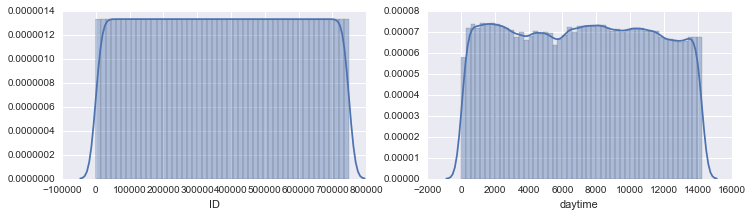

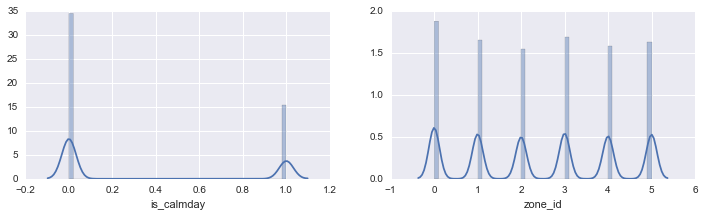

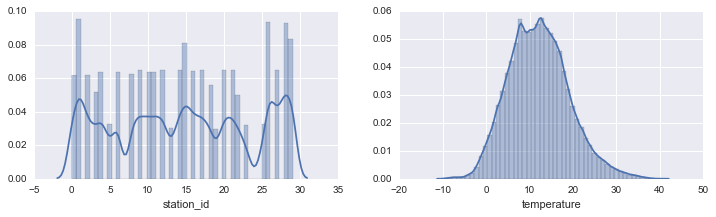

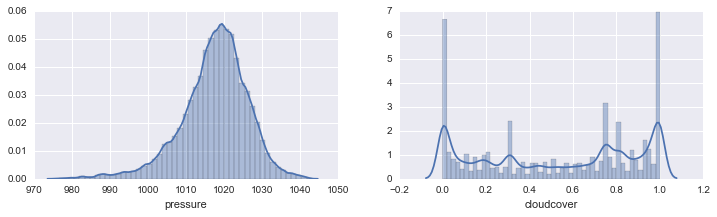

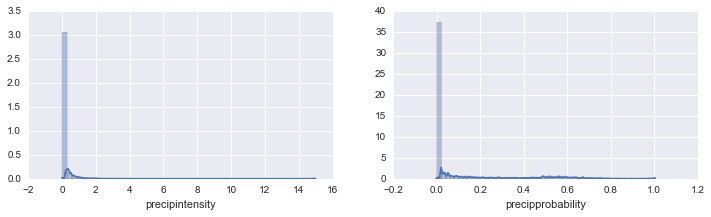

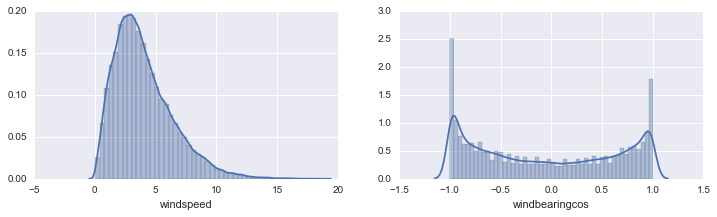

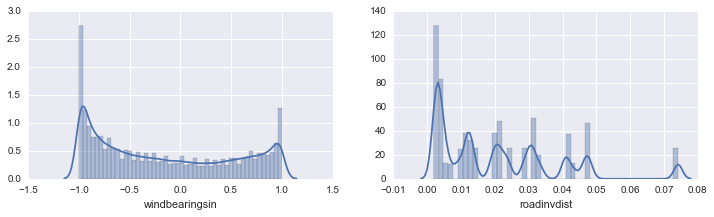

In [13]:
# Look at the distribution of all of the numerical features
ncol = 2
nrow = 7
for i in range(nrow):
    fig, axs = plt.subplots(nrows = 1, ncols = ncol, figsize = (12, 3))
    cols = num_features[(i * ncol): (ncol * (i + 1))]
    for j in range(len(axs)):
        sns.distplot(alldata[cols[j]], bins = 50, ax = axs[j])
        axs[j].set(xlabel = cols[j])

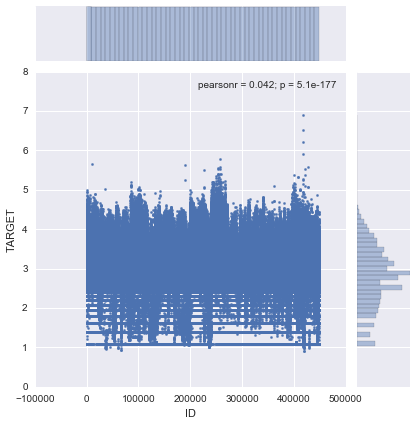

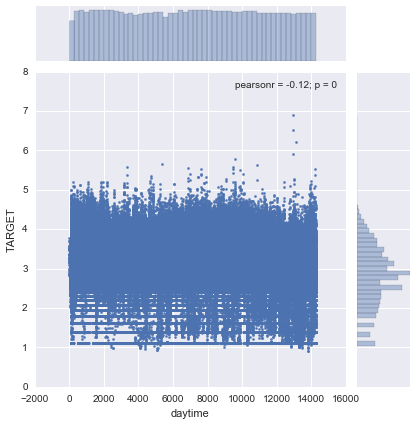

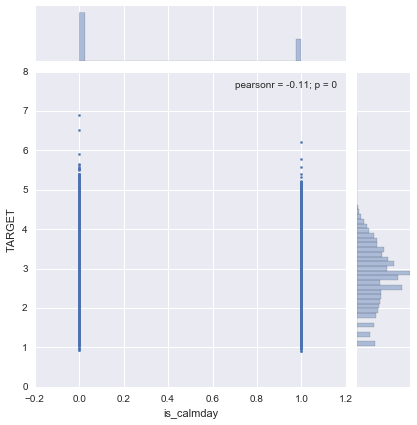

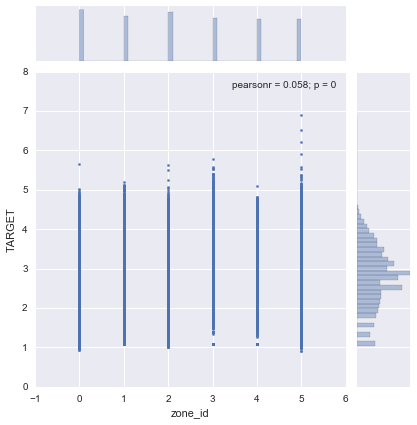

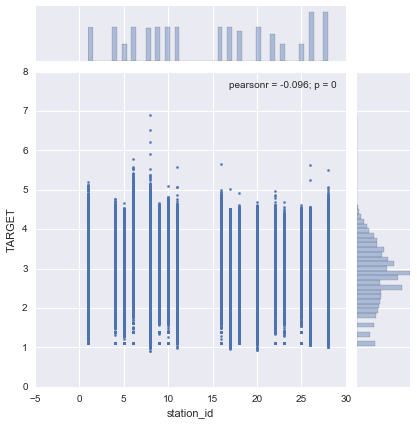

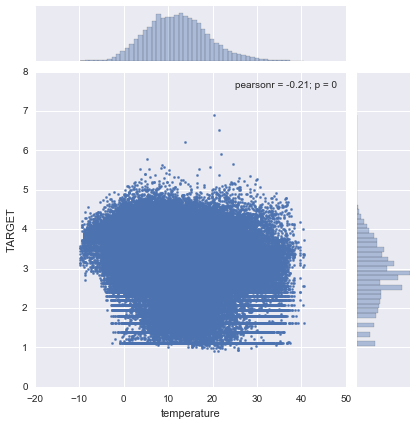

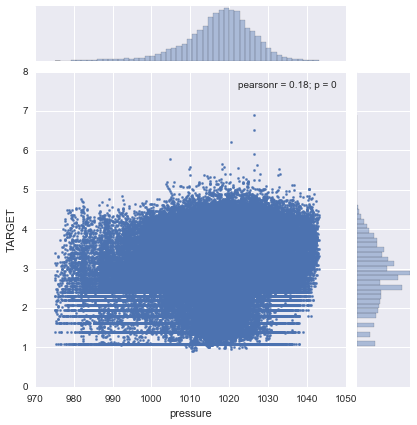

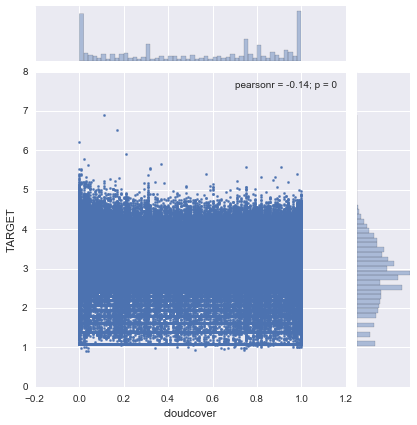

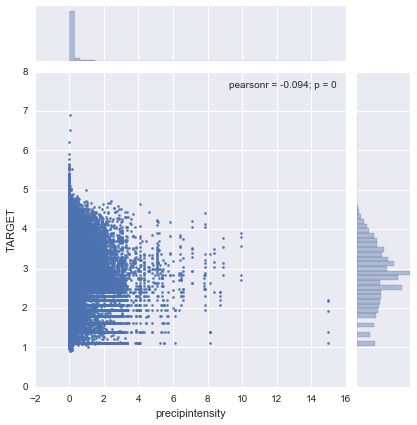

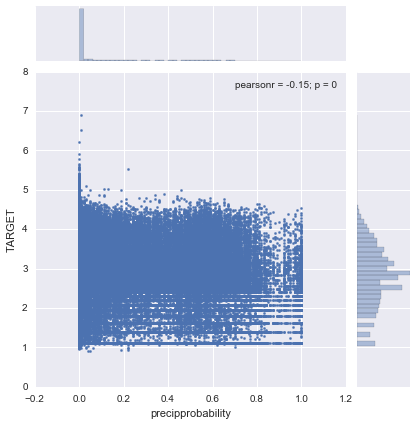

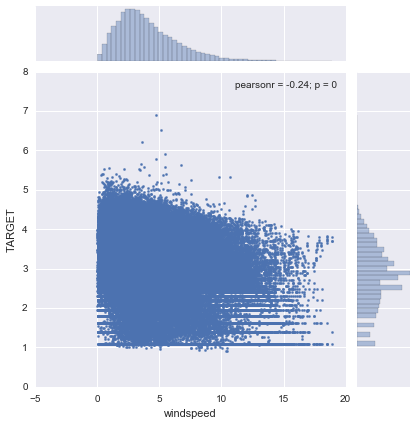

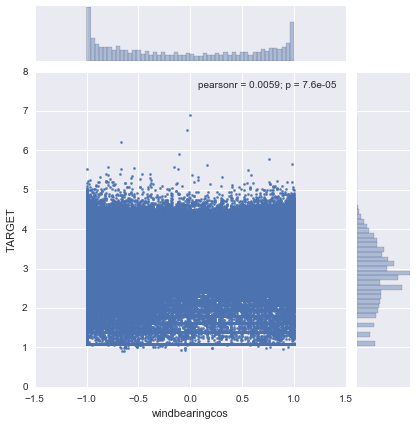

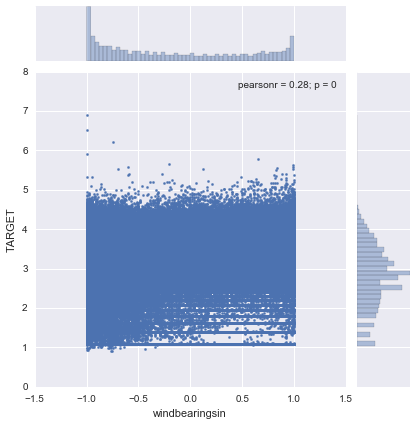

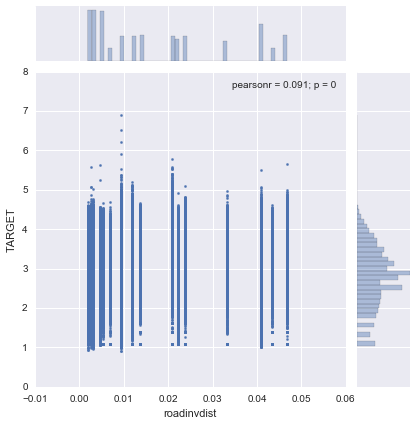

In [14]:
# Plot all the numerical features against the target
sns.jointplot(x = train["ID"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["daytime"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["is_calmday"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["zone_id"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["station_id"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["temperature"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["pressure"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["cloudcover"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["precipintensity"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["precipprobability"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["windspeed"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["windbearingcos"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["windbearingsin"], y = y.TARGET, s = 5)
plt.show()
sns.jointplot(x = train["roadinvdist"], y = y.TARGET, s = 5)
plt.show()

In [15]:
# Let's have a look at station_id
print(train.station_id.value_counts())
print(test.station_id.value_counts())
print("No overlap between train and test sets for stations")

26.000    40719
28.000    40448
20.000    28254
17.000    28254
9.000     28218
16.000    28032
6.000     27832
11.000    27743
1.000     27694
4.000     27674
10.000    27671
8.000     27302
18.000    24454
22.000    21836
25.000    14109
5.000     14090
23.000    13839
Name: station_id, dtype: int64
29.000    36332
15.000    35256
21.000    28243
27.000    28237
12.000    28217
14.000    28192
2.000     26964
0.000     26862
3.000     22562
1.000     13816
13.000    13228
19.000    12982
Name: station_id, dtype: int64
No overlap between train and test sets for stations


daytime : arbitrary value which describe the order in time, on an hourly basis, of the data
So 24 values per day, 168 per week


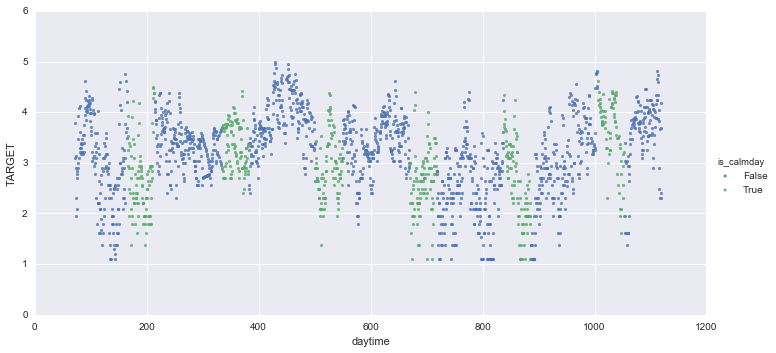

We can see on the above plot about 6 weeks + their respective week-ends
Our CV mechanism must take this temporality into account
-----
How many days/weeks in the test and train datasets?
In train : 
Unique values of daytime : 14256
Number of days : 594.0
Number of weeks : 84.85714285714286
Number of seasons : 6.527472527472527
In test : 
Unique values of daytime : 14243
Number of days : 593.4583333333334
Number of weeks : 84.7797619047619
Number of seasons : 6.521520146520147
So about same length in both sets. Are these 2 covering the same timeframe? Or following each other? Or something else?


,daytime,daytime
0,72.000,72.000
1,72.000,72.000
2,73.000,73.000
3,73.000,73.000
4,74.000,74.000
5,74.000,74.000
6,75.000,75.000
7,75.000,75.000
8,76.000,76.000
9,76.000,76.000


Looks like it is covering the same timeframe


In [16]:
# Let's have a look at daytime
print("daytime : arbitrary value which describe the order in time, on an hourly basis, of the data")
print("So 24 values per day, 168 per week")
temp_df = pd.concat([train, y], axis = 1)
sns.lmplot(x = "daytime", 
           y = "TARGET", 
           data = temp_df.head(2000), 
           hue = "is_calmday", 
           fit_reg = False, 
           scatter_kws = {"s": 10}, 
           aspect = 2)
plt.show()
print("We can see on the above plot about 6 weeks + their respective week-ends")
print("Our CV mechanism must take this temporality into account")
print("-----")
print("How many days/weeks in the test and train datasets?")
print("In train : ")
print("Unique values of daytime : " + str(train.daytime.nunique()))
print("Number of days : " + str(train.daytime.nunique() / 24))
print("Number of weeks : " + str(train.daytime.nunique() / (24 * 7)))
print("Number of seasons : " + str(train.daytime.nunique() / (24 * 7 * 13)))
print("In test : ")
print("Unique values of daytime : " + str(test.daytime.nunique()))
print("Number of days : " + str(test.daytime.nunique() / 24))
print("Number of weeks : " + str(test.daytime.nunique() / (24 * 7)))
print("Number of seasons : " + str(test.daytime.nunique() / (24 * 7 * 13)))
print("So about same length in both sets. Are these 2 covering the same timeframe? Or following each other? Or something else?")
df_head = pd.concat([train.daytime.head(10), test.daytime.head(10)], axis = 1)
display(df_head)
print("Looks like it is covering the same timeframe")

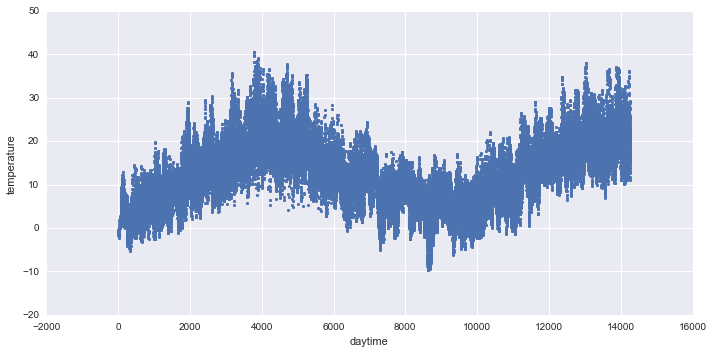

Supposing the data was collected in France, hottest day of the year is around July 20th
On the graph, hottest day of 1st year is about daytime = 3800
There are 24 values of daytime in a day, so 720 in 30 days, which will be one month for us
Winter 1 : 1:920
Spring 1 : 920:3080
Summer 1 : 3080:5240
Autumn 1 : 5240:7400
Winter 2 : 7400:9560
Spring 2 : 9560:11720
Summer 2 : 11720:13880
Autumn 2 : 13880:


In [17]:
# Let's look at temperatures
sns.lmplot(x = "daytime", 
           y = "temperature", 
           data = alldata, 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()
print("Supposing the data was collected in France, hottest day of the year is around July 20th")
print("On the graph, hottest day of 1st year is about daytime = 3800")
print("There are 24 values of daytime in a day, so 720 in 30 days, which will be one month for us")
print("Winter 1 : 1:920")
print("Spring 1 : 920:3080")
print("Summer 1 : 3080:5240")
print("Autumn 1 : 5240:7400")
print("Winter 2 : 7400:9560")
print("Spring 2 : 9560:11720")
print("Summer 2 : 11720:13880")
print("Autumn 2 : 13880:")

In [18]:
# Create season feature
alldata["season"] = alldata.daytime.copy()
alldata.loc[(alldata["daytime"] <= 920) | ((alldata["daytime"] > 7400) & (alldata["daytime"] <= 9560)), "season"] = 1 # winter
alldata.loc[((alldata["daytime"] > 920) & (alldata["daytime"] <= 3080)) | ((alldata["daytime"] > 9560) & (alldata["daytime"] <= 11720)), "season"] = 2 # spring
alldata.loc[((alldata["daytime"] > 3080) & (alldata["daytime"] <= 5240)) | ((alldata["daytime"] > 11720) & (alldata["daytime"] <= 13880)), "season"] = 3 # summer
alldata.loc[((alldata["daytime"] > 5240) & (alldata["daytime"] <= 7400)) | (alldata["daytime"] > 13880), "season"] = 4 # autumn

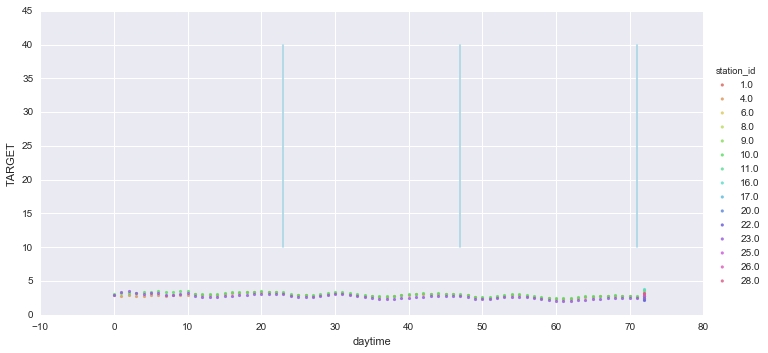

We see a lot of stations started monitoring on daytime 72
It then makes a lot of sense to imagine they start precisely 3 days (72 hours) after the first ones
I guess daytime = 0 is 1h00 of the 1st day of monitoring
Every day we can see 2 high activity periods, upside-down bell-shaped
We can create a new feature based on time of day


In [19]:
# Let's zoom on the 1st 3 days
temp_df = pd.concat([train, y], axis = 1)
temp_df = temp_df[temp_df.daytime <= 72]
temp_df = temp_df[temp_df.pollutant == "NO2"]
#display(temp_df)
sns.lmplot(x = "daytime", 
           y = "TARGET", 
           data = temp_df, 
           fit_reg = False, 
           hue = "station_id", 
           palette = "hls", 
           scatter_kws = {"s": 10}, 
           aspect = 2)
plt.plot([23, 23], [10, 40], "lightblue")
plt.plot([47, 47], [10, 40], "lightblue")
plt.plot([71, 71], [10, 40], "lightblue")
plt.show()
print("We see a lot of stations started monitoring on daytime 72")
print("It then makes a lot of sense to imagine they start precisely 3 days (72 hours) after the first ones")
print("I guess daytime = 0 is 1h00 of the 1st day of monitoring")
print("Every day we can see 2 high activity periods, upside-down bell-shaped")
print("We can create a new feature based on time of day")

In [20]:
# Create hour feature
alldata["hour"] = (alldata["daytime"] + 1) % 24

# Create hour_bin feature
alldata["hour_bin"] = alldata.hour.copy()
alldata.loc[(alldata["hour"] > 10) & (alldata["hour"] <= 19), "hour_bin"] = 1
alldata.loc[alldata["hour"] <= 5, "hour_bin"] = 2
alldata.loc[alldata["hour"] > 19, "hour_bin"] = 3
alldata.loc[(alldata["hour"] > 5) & (alldata["hour"] <= 10), "hour_bin"] = 4

In [21]:
# Create day feature
alldata["day"] = (alldata["daytime"] / 24) + 1
alldata.day = alldata.day.apply(int)

# Create week feature
alldata["week"] = (alldata["daytime"] / (24 * 7)) + 1
alldata.week = alldata.week.apply(int)

# Create month feature
alldata["month"] = (alldata["daytime"] / (24 * 7 * 4.5)) + 1
alldata.month = alldata.month.apply(int)

In [22]:
# Imputing NAs
print("When no data is provided, it means that: \
\n- No land use is encompassed within the buffer for land use data \
\n- No data is available for meteorological parameters")

# Look at missing values
print("NAs : " + str(alldata.isnull().values.sum()))
print(alldata.isnull().sum())
print("A LOT of missing values to imput")
alldata.isnull().sum()

# Land use data -> replace by 0
alldata.loc[:, "hlres_50"] = alldata.loc[:, "hlres_50"].fillna(0)
alldata.loc[:, "hlres_100"] = alldata.loc[:, "hlres_100"].fillna(0)
alldata.loc[:, "hlres_300"] = alldata.loc[:, "hlres_300"].fillna(0)
alldata.loc[:, "hlres_500"] = alldata.loc[:, "hlres_500"].fillna(0)
alldata.loc[:, "hlres_1000"] = alldata.loc[:, "hlres_1000"].fillna(0)
alldata.loc[:, "hldres_50"] = alldata.loc[:, "hldres_50"].fillna(0)
alldata.loc[:, "hldres_100"] = alldata.loc[:, "hldres_100"].fillna(0)
alldata.loc[:, "hldres_300"] = alldata.loc[:, "hldres_300"].fillna(0)
alldata.loc[:, "hldres_500"] = alldata.loc[:, "hldres_500"].fillna(0)
alldata.loc[:, "hldres_1000"] = alldata.loc[:, "hldres_1000"].fillna(0)
alldata.loc[:, "route_100"] = alldata.loc[:, "route_100"].fillna(0)
alldata.loc[:, "route_300"] = alldata.loc[:, "route_300"].fillna(0)
alldata.loc[:, "route_500"] = alldata.loc[:, "route_500"].fillna(0)
alldata.loc[:, "route_1000"] = alldata.loc[:, "route_1000"].fillna(0)
alldata.loc[:, "industry_1000"] = alldata.loc[:, "industry_1000"].fillna(0)
alldata.loc[:, "port_5000"] = alldata.loc[:, "port_5000"].fillna(0)
alldata.loc[:, "natural_5000"] = alldata.loc[:, "natural_5000"].fillna(0)
alldata.loc[:, "green_5000"] = alldata.loc[:, "green_5000"].fillna(0)

print("After NA imputing, remaining NAs : " + str(alldata.isnull().values.sum()))
print(alldata.shape)

When no data is provided, it means that: 
- No land use is encompassed within the buffer for land use data 
- No data is available for meteorological parameters
NAs : 5831954
ID                        0
daytime                   0
is_calmday                0
zone_id                   0
station_id                0
pollutant                 0
temperature               0
pressure                  0
cloudcover                0
precipintensity           0
precipprobability         0
windspeed                 0
windbearingcos            0
windbearingsin            0
roadinvdist               0
hlres_50             630452
hlres_100            514029
hlres_300            514029
hlres_500            514029
hlres_1000           141020
hldres_50            365300
hldres_100           248877
hldres_300           248877
hldres_500           248877
hldres_1000               0
route_100            622492
route_300            381937
route_500            141020
route_1000                0
industry_1000

In [23]:
'''# Some numerical features are actually really categories
alldata = alldata.replace({"zone_id" : {1 : "Z1", 2 : "Z2", 3 : "Z3", 4 : "Z4", 5 : "Z5"}})
alldata = alldata.replace({"station_id" : {1 : "S1", 2 : "S2", 3 : "S3", 4 : "S4", 5 : "S5", 6 : "S6", 7 : "S7", 8 : "S8", 
                                           9 : "S9", 10 : "S10", 11 : "S11", 12 : "S12", 13 : "S13", 14 : "S14", 15 : "S15", 
                                           16 : "S16", 17 : "S17", 18 : "S18", 19 : "S19", 20 : "S20", 21 : "S21", 22 : "S22", 
                                           23 : "S23", 24 : "S24", 25 : "S25", 26 : "S26", 27 : "S27", 28 : "S28", 29 : "S29"}})

cat_features = alldata.select_dtypes(include = ["object"]).columns
num_features = alldata.select_dtypes(exclude = ["object"]).columns'''

'# Some numerical features are actually really categories\nalldata = alldata.replace({"zone_id" : {1 : "Z1", 2 : "Z2", 3 : "Z3", 4 : "Z4", 5 : "Z5"}})\nalldata = alldata.replace({"station_id" : {1 : "S1", 2 : "S2", 3 : "S3", 4 : "S4", 5 : "S5", 6 : "S6", 7 : "S7", 8 : "S8", \n                                           9 : "S9", 10 : "S10", 11 : "S11", 12 : "S12", 13 : "S13", 14 : "S14", 15 : "S15", \n                                           16 : "S16", 17 : "S17", 18 : "S18", 19 : "S19", 20 : "S20", 21 : "S21", 22 : "S22", \n                                           23 : "S23", 24 : "S24", 25 : "S25", 26 : "S26", 27 : "S27", 28 : "S28", 29 : "S29"}})\n\ncat_features = alldata.select_dtypes(include = ["object"]).columns\nnum_features = alldata.select_dtypes(exclude = ["object"]).columns'

List of numerical features linearily correlated at more than 50% :
hldres_300 hldres_500 : 0.992183818897
hldres_100 hldres_300 : 0.982967329942
hlres_100 hlres_300 : 0.979200404651
hlres_300 hlres_500 : 0.977463803622
hldres_100 hldres_500 : 0.963981729654
green_5000 natural_5000 : 0.946864992424
hlres_100 hlres_500 : 0.931884633842
hldres_300 hldres_1000 : 0.862977060315
hldres_100 hldres_1000 : 0.854314771249
hldres_500 hldres_1000 : 0.853489507447
hldres_50 hldres_100 : 0.847368621961
route_300 route_500 : 0.82345291807
hldres_50 hldres_300 : 0.788118976558
hldres_50 hldres_500 : 0.761287007826
hlres_50 hlres_100 : 0.745231785789
route_500 route_1000 : 0.739276457574
precipintensity precipprobability : 0.719913895336
hlres_50 hlres_500 : 0.712165127707
hlres_50 hlres_300 : 0.711459843761
route_300 route_1000 : 0.675735335945
hlres_500 green_5000 : 0.667209079704
zone_id hldres_500 : -0.655029581874
zone_id hldres_300 : -0.654890841898
hlres_500 natural_5000 : 0.65423639406
route_30

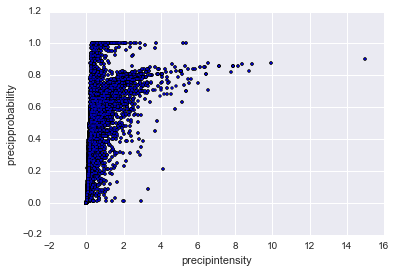

In [24]:
# Look at linear correlations between numerical features
nums = len(num_features)
corr = alldata[num_features].corr()
corr_list = []
for i in range(0, nums): 
    for j in range(i + 1, nums): 
        if (abs(corr.iloc[i, j]) >= 0.50):
            corr_list.append([corr.iloc[i, j], i, j])
s_corr_list = sorted(corr_list, key = lambda x: -abs(x[0]))
print("List of numerical features linearily correlated at more than 50% :")
for v, i, j in s_corr_list:
    print(str(num_features[i]) + " " + str(num_features[j]) + " : " + str(v))
    
# Plot some interesting correlations
plt.scatter(alldata.precipintensity, alldata.precipprobability , c = "blue", marker = "s", s = 2)
plt.xlabel("precipintensity")
plt.ylabel("precipprobability ")
plt.show()

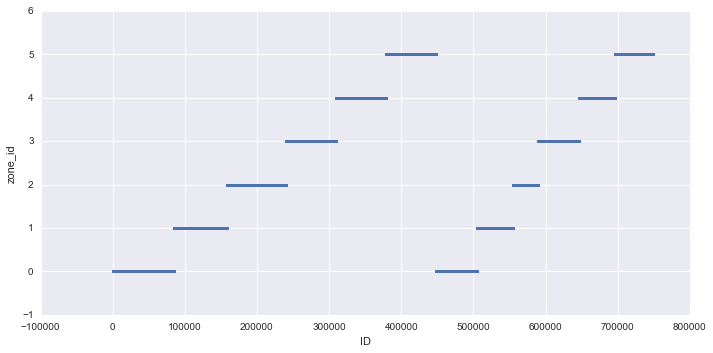

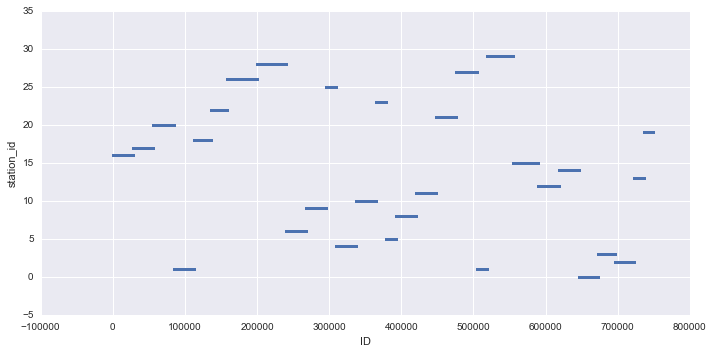

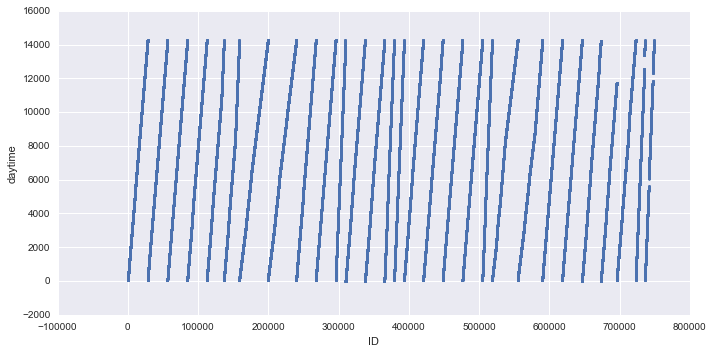

There is a pretty clear structure in the ID field
IDs are grouped by train/test, then by zone_id, then by station_id inside each zone, then by daytime inside each station
Slope is not identical between every station as not all stations record all pollutants
There may be information to be gained by removing the 1st level (train/test)


In [25]:
# Let's look at the ID field
sns.lmplot(x = "ID", 
           y = "zone_id", 
           data = alldata, 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()
sns.lmplot(x = "ID", 
           y = "station_id", 
           data = alldata, 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()
sns.lmplot(x = "ID", 
           y = "daytime", 
           data = alldata, 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()
print("There is a pretty clear structure in the ID field")
print("IDs are grouped by train/test, then by zone_id, then by station_id inside each zone, then by daytime inside each station")
print("Slope is not identical between every station as not all stations record all pollutants")
print("There may be information to be gained by removing the 1st level (train/test)")

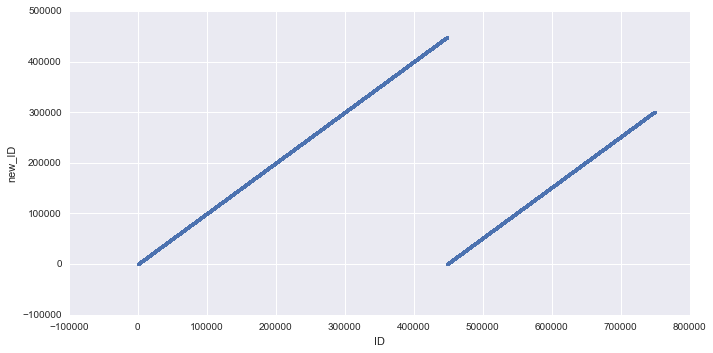

In [26]:
# Create new id field
alldata = alldata.sort_values(["zone_id", "station_id", "daytime"], axis = 0)
alldata["new_ID"] = alldata.index
sns.lmplot(x = "ID", 
           y = "new_ID", 
           data = alldata, 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()

In [27]:
# Create some simplified versions of existing features
alldata["precipIntZero"] = (alldata["precipintensity"] == 0) * 1
alldata["precipProbZero"] = (alldata["precipprobability"] == 0) * 1
alldata["tempNeg"] = (alldata["temperature"] < 0) * 1
alldata["pressureHigh"] = (alldata["pressure"] > 1020) * 1

In [28]:
# Create new features : polynomials on original numerical features
best_feats = "ID, pressure, temperature, windspeed, daytime, windbearingcos, cloudcover, \
windbearingsin, precipintensity, roadinvdist, precipprobability".split(", ")

for orig_feat in best_feats :
    feat = orig_feat + "-p2"
    alldata[feat] = alldata[orig_feat] ** 2
    feat = orig_feat + "-p3"
    alldata[feat] = alldata[orig_feat] ** 3
    feat = orig_feat + "-sq"
    alldata[feat] = np.sqrt(alldata[orig_feat])

In [29]:
# Create new features : aggregations by zone
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y], axis = 1)

meansByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).mean()
mediansByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).median()
maxsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).max()
minsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).min()
sumsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).sum()
stdsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).std()

def replaceByMean(group):
    return meansByZone[group.name]
def replaceByMedian(group):
    return mediansByZone[group.name]
def replaceByMax(group):
    return maxsByZone[group.name]
def replaceByMin(group):
    return minsByZone[group.name]
def replaceBySum(group):
    return sumsByZone[group.name]
def replaceByStd(group):
    return stdsByZone[group.name]

train.loc[:, "meanZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMean)
test.loc[:, "meanZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMean)
train.loc[:, "medianZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedian)
test.loc[:, "medianZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedian)
train.loc[:, "maxZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMax)
test.loc[:, "maxZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMax)
train.loc[:, "minZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMin)
test.loc[:, "minZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMin)
train.loc[:, "sumZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySum)
test.loc[:, "sumZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySum)
train.loc[:, "stdZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStd)
test.loc[:, "stdZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStd)

alldata = pd.concat([train, test], axis = 0)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# Create new features : aggregations by hour
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y], axis = 1)

meansByHour = temp_train["TARGET"].groupby(temp_train["hour"]).mean()
mediansByHour = temp_train["TARGET"].groupby(temp_train["hour"]).median()
maxsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).max()
minsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).min()
sumsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).sum()
stdsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).std()

def replaceByMean(group):
    return meansByHour[group.name]
def replaceByMedian(group):
    return mediansByHour[group.name]
def replaceByMax(group):
    return maxsByHour[group.name]
def replaceByMin(group):
    return minsByHour[group.name]
def replaceBySum(group):
    return sumsByHour[group.name]
def replaceByStd(group):
    return stdsByHour[group.name]

train.loc[:, "meanHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMean)
test.loc[:, "meanHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMean)
train.loc[:, "medianHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMedian)
test.loc[:, "medianHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMedian)
train.loc[:, "maxHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMax)
test.loc[:, "maxHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMax)
train.loc[:, "minHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMin)
test.loc[:, "minHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByMin)
train.loc[:, "sumHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceBySum)
test.loc[:, "sumHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceBySum)
train.loc[:, "stdHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByStd)
test.loc[:, "stdHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["hour"]).transform(replaceByStd)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : aggregations by pollutant
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y], axis = 1)

meansByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).mean()
mediansByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).median()
maxsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).max()
minsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).min()
sumsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).sum()
stdsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).std()

def replaceByMean(group):
    return meansByPollutant[group.name]
def replaceByMedian(group):
    return mediansByPollutant[group.name]
def replaceByMax(group):
    return maxsByPollutant[group.name]
def replaceByMin(group):
    return minsByPollutant[group.name]
def replaceBySum(group):
    return sumsByPollutant[group.name]
def replaceByStd(group):
    return stdsByPollutant[group.name]

train.loc[:, "meanPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMean)
test.loc[:, "meanPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMean)
train.loc[:, "medianPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMedian)
test.loc[:, "medianPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMedian)
train.loc[:, "maxPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMax)
test.loc[:, "maxPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMax)
train.loc[:, "minPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMin)
test.loc[:, "minPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByMin)
train.loc[:, "sumPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceBySum)
test.loc[:, "sumPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceBySum)
train.loc[:, "stdPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByStd)
test.loc[:, "stdPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["pollutant"]).transform(replaceByStd)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : aggregations by operation
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y], axis = 1)

meansByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).mean()
meansByHour = temp_train["TARGET"].groupby(temp_train["hour"]).mean()
meansByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).mean()

def replaceByMeanZone(group):
    return meansByZone[group.name]
def replaceByMeanHour(group):
    return meansByZone[group.name]
def replaceByMeanPollutant(group):
    return meansByZone[group.name]

train.loc[:, "meanZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMeanZone)
test.loc[:, "meanZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMeanZone)
train.loc[:, "meanHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMeanHour)
test.loc[:, "meanHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMeanHour)
train.loc[:, "meanPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMeanPollutant)
test.loc[:, "meanPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMeanPollutant)

mediansByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).median()
mediansByHour = temp_train["TARGET"].groupby(temp_train["hour"]).median()
mediansByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).median()

def replaceByMedianZone(group):
    return mediansByZone[group.name]
def replaceByMedianHour(group):
    return mediansByZone[group.name]
def replaceByMedianPollutant(group):
    return mediansByZone[group.name]

train.loc[:, "medianZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedianZone)
test.loc[:, "medianZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedianZone)
train.loc[:, "medianHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedianHour)
test.loc[:, "medianHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedianHour)
train.loc[:, "medianPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedianPollutant)
test.loc[:, "medianPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMedianPollutant)

maxsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).max()
maxsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).max()
maxsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).max()

def replaceByMaxZone(group):
    return maxsByZone[group.name]
def replaceByMaxHour(group):
    return maxsByZone[group.name]
def replaceByMaxPollutant(group):
    return maxsByZone[group.name]

train.loc[:, "maxZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMaxZone)
test.loc[:, "maxZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMaxZone)
train.loc[:, "maxHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMaxHour)
test.loc[:, "maxHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMaxHour)
train.loc[:, "maxPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMaxPollutant)
test.loc[:, "maxPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMaxPollutant)

minsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).min()
minsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).min()
minsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).min()

def replaceByMinZone(group):
    return minsByZone[group.name]
def replaceByMinHour(group):
    return minsByZone[group.name]
def replaceByMinPollutant(group):
    return minsByZone[group.name]

train.loc[:, "minZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMinZone)
test.loc[:, "minZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMinZone)
train.loc[:, "minHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMinHour)
test.loc[:, "minHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMinHour)
train.loc[:, "minPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMinPollutant)
test.loc[:, "minPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByMinPollutant)

sumsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).sum()
sumsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).sum()
sumsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).sum()

def replaceBySumZone(group):
    return sumsByZone[group.name]
def replaceBySumHour(group):
    return sumsByZone[group.name]
def replaceBySumPollutant(group):
    return sumsByZone[group.name]

train.loc[:, "sumZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySumZone)
test.loc[:, "sumZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySumZone)
train.loc[:, "sumHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySumHour)
test.loc[:, "sumHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySumHour)
train.loc[:, "sumPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySumPollutant)
test.loc[:, "sumPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceBySumPollutant)

stdsByZone = temp_train["TARGET"].groupby(temp_train["zone_id"]).std()
stdsByHour = temp_train["TARGET"].groupby(temp_train["hour"]).std()
stdsByPollutant = temp_train["TARGET"].groupby(temp_train["pollutant"]).std()

def replaceByStdZone(group):
    return stdsByZone[group.name]
def replaceByStdHour(group):
    return stdsByZone[group.name]
def replaceByStdPollutant(group):
    return stdsByZone[group.name]

train.loc[:, "stdZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStdZone)
test.loc[:, "stdZone"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStdZone)
train.loc[:, "stdHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStdHour)
test.loc[:, "stdHour"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStdHour)
train.loc[:, "stdPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStdPollutant)
test.loc[:, "stdPollutant"] = temp_train.loc[:, "TARGET"].groupby(temp_train["zone_id"]).transform(replaceByStdPollutant)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : median by zone then by pollutant
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y.TARGET], axis = 1)

medians = temp_train.groupby(["zone_id", "pollutant"]).TARGET.median()

def replaceByMedian(group):
    return medians[group.name]

train.loc[:, "medianZonePollutant"] = temp_train.groupby(["zone_id", "pollutant"]).TARGET.transform(replaceByMedian)
test.loc[:, "medianZonePollutant"] = temp_train.groupby(["zone_id", "pollutant"]).TARGET.transform(replaceByMedian)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : median by zone then by pollutant then by week
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y.TARGET], axis = 1)

medians = temp_train.groupby(["zone_id", "pollutant", "week"]).TARGET.median()

def replaceByMedian(group):
    return medians[group.name]

train.loc[:, "medianZonePollutantWeek"] = temp_train.groupby(["zone_id", "pollutant", "week"]).TARGET.transform(replaceByMedian)
test.loc[:, "medianZonePollutantWeek"] = temp_train.groupby(["zone_id", "pollutant", "week"]).TARGET.transform(replaceByMedian)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : median by zone then by pollutant then by day
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y.TARGET], axis = 1)

medians = temp_train.groupby(["zone_id", "pollutant", "day"]).TARGET.median()

def replaceByMedian(group):
    return medians[group.name]

train.loc[:, "medianZonePollutantDay"] = temp_train.groupby(["zone_id", "pollutant", "day"]).TARGET.transform(replaceByMedian)
test.loc[:, "medianZonePollutantDay"] = temp_train.groupby(["zone_id", "pollutant", "day"]).TARGET.transform(replaceByMedian)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : median by zone then by pollutant then by hour
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

temp_train = pd.concat([train, y.TARGET], axis = 1)

medians = temp_train.groupby(["zone_id", "pollutant", "hour"]).TARGET.median()

def replaceByMedian(group):
    return medians[group.name]

train.loc[:, "medianZonePollutantHour"] = temp_train.groupby(["zone_id", "pollutant", "hour"]).TARGET.transform(replaceByMedian)
test.loc[:, "medianZonePollutantHour"] = temp_train.groupby(["zone_id", "pollutant", "hour"]).TARGET.transform(replaceByMedian)

alldata = pd.concat([train, test], axis = 0)

In [ ]:
# Create new features : combining the numerical features
best_feats = "ID, pressure, temperature, windspeed, daytime, windbearingcos, cloudcover, \
windbearingsin, precipintensity, roadinvdist, precipprobability".split(", ")
best_feats = "ID, daytime, temperature, cloudcover, windspeed".split(", ")

for combo in itertools.combinations(best_feats, 2) :
    feat = combo[0] + "+" + combo[1]
    alldata[feat] = alldata[combo[0]] + alldata[combo[1]]
    feat = combo[0] + "-" + combo[1]
    alldata[feat] = alldata[combo[0]] - alldata[combo[1]]
        feat = combo[0] + "*" + combo[1]
    alldata[feat] = alldata[combo[0]] * alldata[combo[1]]
    feat = combo[0] + "/" + combo[1]
    alldata[feat] = alldata[combo[0]] / alldata[combo[1]]

In [ ]:
cat_features = alldata.select_dtypes(include = ["object"]).columns
num_features = alldata.select_dtypes(exclude = ["object"]).columns

train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

In [ ]:
# Log transform of the skewed original numerical features to lessen impact of outliers
skewness = train[num_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 1.5]
print(str(skewness.shape[0]) + " skewed original numerical features to log transform in train")
print(skewness)
skewed_features = skewness.index
for feat in skewed_features:
        train[feat] = np.log1p(train[feat])
        test[feat] = np.log1p(test[feat])
        #train[feat] = train[feat] + 1
        #test[feat] = test[feat] + 1
        #train[feat], lam = boxcox(train[feat])
        #test[feat], lam = boxcox(test[feat])

In [ ]:
# Standardize numerical features
stdSc = StandardScaler()
train.loc[:, num_features] = stdSc.fit_transform(train.loc[:, num_features])
test.loc[:, num_features] = stdSc.transform(test.loc[:, num_features])

In [ ]:
# Check for levels that are missing in one set, we might overfit on those
def filter_cat(x, data) :
    if (x in data) :
        return (np.nan)
    else :
        return (x)

for column in cat_features :
    if train[column].nunique() != test[column].nunique() :
        # Replace levels present only in one set by NA (no info to take from those)
        unique_train = set(train[column].unique())
        unique_test = set(test[column].unique())
        only_in_train = unique_train - unique_test
        only_in_test = unique_test - unique_train
        only_in_one = only_in_train.union(only_in_test)        
        alldata[column] = alldata[column].apply(lambda x: filter_cat(x, only_in_one))

In [ ]:
# Encode cat features
print(alldata.shape)
alldata = pd.get_dummies(alldata)
print(alldata.shape)

train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

In [ ]:
'''# Write data in CSV files
test_ids.to_csv("clean_data/test_ids.csv", index = False)
y.to_csv("clean_data/y.csv", index = False)
train.to_csv("clean_data/train.csv", index = False)
test.to_csv("clean_data/test.csv", index = False)'''